In [2]:
# imports 
import numpy as np
import matplotlib.pyplot as plt

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] # hack, but works

from Dragonfly44_SFH.utils import prospect_io, plotting, transforms
from figure_style import *
from Dragonfly44_SFH.utils.styles import *

from copy import deepcopy

In [4]:
# read the observed data file for Dragonfly44

path_data = path_base+ "Dragonfly44_SFH/data/"
file_data = path_data+"Dragonfly44/obs_phot_specKCWI_sigma110.h5"

# construct a dictionary from the h5py file values
obs = {}
import h5py
with h5py.File(file_data,'r') as hfile:
    for key in hfile.keys():
        obs[key] = np.copy( hfile[key] )        
filternames = obs['filternames'].tolist() 
# load filter information with sedpy
from sedpy.observate import load_filters
obs["filters"] = load_filters( filternames )

zobs = float(obs['Redshift'])

In [5]:
# construct a SPS model to generate simple models 
from Dragonfly44_SFH.utils.build_sps_model import build_model_sps, build_sps_sps

sps = build_sps_sps()

model = build_model_sps( zobs )

In [6]:
# construct dictionary for mock obsrvations
# basically just contains filter information, 
# including additional filters (i.e., not observed)

obs_mock = dict( wavelength=None, spectrum=None, unc=None, mask=None )
    
filternames = obs['filternames'].tolist() + ["jwst_f560w","jwst_f770w"]
N = len(filternames)
phot_filters = load_filters( filternames )
phot_wave = np.array([ f.wave_effective for f in phot_filters ])

obs_mock["filternames"] = filternames
obs_mock["filters"]     = np.copy( phot_filters )
obs_mock["phot_wave"]   = np.copy( phot_wave )

obs_mock['maggies'] = np.zeros( N )
obs_mock['maggies_unc'] = np.zeros( N )
obs_mock['phot_mask'] = np.zeros( N )
    
wave = sps.wavelengths * (1.+zobs )    

In [7]:
def get_models( obs, obs_mock, sps, dust2=0.001, logzsol=-1.26, tage=10.6 ):
    theta = np.copy( model.initial_theta )
    theta[ model.theta_index['dust2'] ] = dust2
    theta[ model.theta_index['logzsol'] ] = logzsol
    theta[ model.theta_index['tage'] ] = tage

    sed,  phot, _ = model.predict( theta, obs=obs_mock, sps=sps)
    spec, _, _ = model.predict( theta, obs=obs,  sps=sps)
    
    return dict( theta=theta, sed=sed, phot=phot, spec=spec )

In [7]:
# construct three sets of SPS models 
# each having slightly different parameters

# fiducial
sps_model_fiducial = get_models( obs, obs_mock, sps, dust2=0.001, logzsol=-1.26, tage=10.6 )

# older
sps_model_older = get_models( obs, obs_mock, sps, dust2=0.001, logzsol=-1.26, tage=13.4 )

# dustier
sps_model_dustier = get_models( obs, obs_mock, sps, dust2=0.2, logzsol=-1.26, tage=10.6 )

In [10]:
sps_model_fiducial['params'] = dict( color='0.5', lw=1, ls='-')
sps_model_older['params'] = dict( color='m', lw=1., dashes=(4,2))
sps_model_dustier['params'] = dict( color='c', lw=2, ls='-')


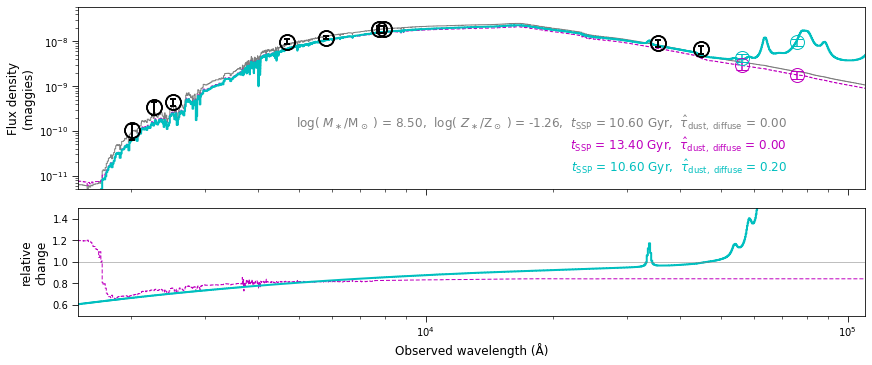

In [12]:
fs = 12
fig, axes = plt.subplots(2,1,figsize=(fig_width_two, textheight*0.3), gridspec_kw={"height_ratios":[1.7,1]}, sharex=False)
ax1,ax1b = axes.flatten()

if True: # SED 
    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=15, mew=1.5) 

    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=15, mew=1.5) 

    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=15, mew=1.5) 
    
    
if True: # models
    
    
    for sps_model in [ sps_model_fiducial, sps_model_older, sps_model_dustier ]:
        ax1.step( wave, sps_model['sed'], where='post', zorder=0, **sps_model['params'] )
        
    ax1b.axhline(1, color=sps_model_fiducial['params']['color'], lw=0.5 )
    
    for sps_model in [ sps_model_older, sps_model_dustier ]:
        rspec = sps_model['spec'] / sps_model_fiducial['spec']
        rsed = sps_model['sed'] / sps_model_fiducial['sed']
        
        ax1b.step( wave, rsed, where='post', zorder=0, **sps_model['params'] )
           
for sps_model in [ sps_model_older, sps_model_dustier ]:
    snr = 5
    mask = ['jwst' in f for f in obs_mock['filternames']]
    y = sps_model['phot']
    ey = y/snr
    
    ax1.errorbar( obs_mock['phot_wave'][mask], y[mask], yerr=ey[mask], \
                  fmt=' ', color=sps_model['params']['color'], marker='o', 
                  ms=14, mec=sps_model['params']['color'], mfc='None', capsize=6 )
            
            
if True: # model param labels 
    fmt = "{{0:{0}}}".format(".2f").format 
    
    label_params = [r"$t_\mathrm{SSP}$",\
                    r"$\log(~M_\ast/\mathrm{M}_\odot~)$",\
                    r"$\log(~Z_\ast/\mathrm{Z}_\odot~)$", \
                    r"$\hat{\tau}_\mathrm{dust,~diffuse}$"]
    fill_label1 = lambda theta : "{1} = {5},  {2} = {6},  {0} = {4} Gyr,  {3} = {7}".format( *label_params, 
                                   fmt(theta[3]), fmt(np.log10(theta[0])), fmt(theta[1]), fmt(theta[2]) )
    fill_label2 = lambda theta : "{0} = {4} Gyr,  {3} = {7}".format( *label_params, 
                                   fmt(theta[3]), fmt(np.log10(theta[0])), fmt(theta[1]), fmt(theta[2]) )
    
    an_params = dict( xy=(0,0), ha='right', xycoords='axes fraction', fontsize=12 )
    ax1.annotate( fill_label1( sps_model_fiducial['theta'] ), 
                  xytext=(0.9,0.34), color=sps_model_fiducial['params']['color'], **an_params)
    ax1.annotate( fill_label2( sps_model_older['theta'] ), 
                  xytext=(0.9,0.22), color=sps_model_older['params']['color'], **an_params)
    ax1.annotate( fill_label2( sps_model_dustier['theta'] ), 
                  xytext=(0.9,0.1), color=sps_model_dustier['params']['color'], **an_params )
    
if True: # plot adjustments    

    ax1.set( xscale='log', yscale='log', xlim=(1.5e3, 1.1e5), ylim=(5e-12,6e-8), xticklabels=[] )
    ax1.set_ylabel('Flux density\n(maggies)', fontsize=fs)    
    ax1b.set( xscale='log', yscale='linear', xlim=ax1.get_xlim(), ylim=(5e-1,1.5) )
    ax1b.set_xlabel(u"Observed wavelength (\u00c5)", fontsize=fs)   
    ax1b.set_ylabel(u"relative\nchange", fontsize=fs)  
    
    for ax in axes:
        ax.tick_params(direction='out', length=6, which='major')
        ax.tick_params(direction='out', length=3, which='minor')

fig.subplots_adjust( hspace=0.13)
plt.savefig('figures/figC1.pdf', **saveparams )
plt.show()